# Introducción a los modelos de ML - Regresión

In [95]:
import numpy as np
import pandas as pd
import global_vars as gv
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.tree import plot_tree

In [2]:
# Cargamos el dataset
cars = pd.read_csv(f'{gv.GLOBAL_PATH}/data/cars.csv')

In [3]:
def count_var_categ(sample: pd.Series) -> pd.DataFrame:
    conteo = sample.value_counts().reset_index()
    total = float(np.sum(conteo['count']))
    conteo['Porc %'] = np.round(conteo['count']/total*100,2)
    return conteo

In [4]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'MAE: {mae}, R2: {r2}')
    return mae, r2

In [5]:
# Para modelos lineales (get_dummies y escalado)
def preprocess_linear_models_data(X_test, X_train):
    X_train_cop = X_train.copy()
    X_test_cop = X_test.copy()
    X_train_cop['split'] = 'train'
    X_test_cop['split'] = 'test'
    X = pd.concat([X_train_cop, X_test_cop], axis=0, ignore_index=True)
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.columns.difference(numeric_cols)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_cols]))
    X_scaled.columns = numeric_cols
    X_final = pd.concat([X_scaled, X[categorical_cols]], axis=1)
    X_dum = pd.get_dummies(X_final, drop_first=True, dtype='int')
    X_train_dum = X_dum.loc[X_dum['split_train'] == 1].drop('split_train', axis=1)
    X_test_dum = X_dum.loc[~(X_dum['split_train'] == 1)].drop('split_train', axis=1)
    return X_train_dum.reset_index().drop('index', axis=1), X_test_dum.reset_index().drop('index', axis=1)

In [6]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [7]:
# Generar una heurística para agrupar Make por precio MRSP con segmentación
cars['Make_segment'] = cars['Make']

cars.loc[cars['Make'].isin(['Chevrolet', 'Ford', 'Dodge', 'GMC', 'Chrysler', 'Jeep', 'Ram', 'Buick', 'Cadillac', 'Lincoln']), 'Make_segment'] = 'American'
cars.loc[cars['Make'].isin(['Toyota', 'Nissan', 'Honda', 'Mazda', 'Mitsubishi', 'Subaru', 'Suzuki', 'Hyundai', 'Kia']), 'Make_segment'] = 'Japanese'
cars.loc[cars['Make'].isin(['Mercedes-Benz', 'BMW', 'Audi', 'Volkswagen', 'Volvo', 'Porsche', 'Jaguar', 'Land Rover', 'MINI', 'Maserati', 'Alfa Romeo', 'Genesis', 'Tesla', 'Fiat', 'Bentley', 'Rolls-Royce', 'Lamborghini', 'Lotus', 'McLaren', 'Bugatti']), 'Make_segment'] = 'European'
cars.loc[cars['Make'].isin(['Acura', 'Infiniti', 'Lexus', 'Aston Martin', 'Ferrari']), 'Make_segment'] = 'Luxury'
cars.loc[cars['Make'].isin(['Pontiac', 'Oldsmobile', 'Saab', 'GMC', 'Chrysler', 'Jeep', 'Plymouth', 'FIAT', 'Scion', 'HUMMER',
                            'Maybach', 'Spyker']), 'Make_segment'] = 'Others'

In [8]:
variables_categoricas = ['Make_segment',  'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size']
variables_numericas = cars.select_dtypes(include=[np.number]).columns

In [9]:
for var in variables_categoricas:
    tmp = count_var_categ(cars[var])
    cars[var] = np.where(cars[var].isin(tmp[f'{var}'].loc[tmp['Porc %'] < 5]), 'Other', cars[var])

In [10]:
variables_modelo = list(variables_numericas) + variables_categoricas

In [11]:
print(variables_modelo)

['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity', 'MSRP', 'Make_segment', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size']


In [12]:
cars.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
Make_segment            0
dtype: int64

In [13]:
cars.dropna(inplace=True)

In [14]:
X = cars[variables_modelo].drop('MSRP', axis=1)
y = cars['MSRP']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
print(f'train: {X_train.shape}, test: {X_test.shape}')

train: (5658, 12), test: (2426, 12)


In [17]:
X_train_dum, X_test_dum = preprocess_linear_models_data(X_test, X_train)

In [18]:
X_train_dum.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Driven_Wheels_four wheel drive,Driven_Wheels_front wheel drive,Driven_Wheels_rear wheel drive,...,Engine Fuel Type_regular unleaded,Make_segment_European,Make_segment_Japanese,Make_segment_Luxury,Make_segment_Others,Transmission Type_AUTOMATIC,Transmission Type_MANUAL,Transmission Type_Other,Vehicle Size_Large,Vehicle Size_Midsize
0,0.623872,-0.753439,-0.942793,0.652370,0.951955,1.179732,0.360457,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0.623872,-0.301251,-0.942793,0.652370,0.951955,0.341687,1.709334,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,-1.908739,-1.144756,0.117669,-1.574724,-0.731984,-0.496358,-0.646073,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,0.149007,0.437903,0.117669,0.652370,-0.343383,-0.356684,-0.926176,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,-1.592163,-0.736047,0.117669,-1.574724,-0.861518,-0.636032,-0.672244,0,0,1,...,1,0,0,0,1,1,0,0,0,0


In [19]:
print(f'train:{X_train_dum.shape}, test:{X_test_dum.shape}')

train:(5658, 23), test:(2426, 23)


In [20]:
X_train.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Make_segment,Engine Fuel Type,Transmission Type,Driven_Wheels,Vehicle Size
6227,2016,188.0,4.0,4.0,34,28,2009,Japanese,premium unleaded (recommended),MANUAL,front wheel drive,Compact
150,2016,240.0,4.0,4.0,34,22,3916,European,premium unleaded (required),AUTOMATIC,all wheel drive,Midsize
1721,2000,143.0,6.0,2.0,21,16,586,Japanese,flex-fuel (unleaded/E85),MANUAL,rear wheel drive,Compact
4307,2013,325.0,6.0,4.0,24,17,190,Luxury,premium unleaded (recommended),AUTOMATIC,all wheel drive,Midsize
9794,2002,190.0,6.0,2.0,20,15,549,Others,regular unleaded,AUTOMATIC,rear wheel drive,Compact


In [21]:
# Label encoding para X_train y X_test
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for var in variables_categoricas:
    X_train[var] = le.fit_transform(X_train[var])
    X_test[var] = le.transform(X_test[var])

In [22]:
X_train.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Make_segment,Engine Fuel Type,Transmission Type,Driven_Wheels,Vehicle Size
6227,2016,188.0,4.0,4.0,34,28,2009,2,2,2,2,0
150,2016,240.0,4.0,4.0,34,22,3916,1,3,1,0,2
1721,2000,143.0,6.0,2.0,21,16,586,2,1,2,3,0
4307,2013,325.0,6.0,4.0,24,17,190,3,2,1,0,2
9794,2002,190.0,6.0,2.0,20,15,549,4,4,1,3,0


## Modelo de regresión Lineal (Baseline)

In [23]:
selected_features = stepwise_selection(X_train_dum, y_train.reset_index().drop('index', axis=1))

Add  Engine HP                      with p-value 0.0
Add  Engine Fuel Type_premium unleaded (required) with p-value 6.70629e-26
Add  Engine Cylinders               with p-value 1.32199e-24
Add  city mpg                       with p-value 1.43046e-36
Add  Driven_Wheels_rear wheel drive with p-value 1.30158e-20
Add  Driven_Wheels_four wheel drive with p-value 1.11809e-23
Add  Vehicle Size_Midsize           with p-value 2.97239e-17
Add  Vehicle Size_Large             with p-value 8.69986e-26
Add  Make_segment_European          with p-value 1.13668e-13
Add  Transmission Type_MANUAL       with p-value 1.85844e-10
Add  Transmission Type_AUTOMATIC    with p-value 8.50153e-11
Add  Popularity                     with p-value 6.13642e-09
Add  Transmission Type_Other        with p-value 0.00014872
Add  Make_segment_Others            with p-value 0.000266693
Add  Make_segment_Japanese          with p-value 0.0031192


In [24]:
# Entrenamiento de modelo con variables seleccionadas
lm = LinearRegression()
lm.fit(X_train_dum[selected_features], y_train)

LinearRegression()

In [25]:
# Predicciones en train
y_pred = lm.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

MAE: 23307.163511181658, R2: 0.502667099000898


In [26]:
# Predicciones en test
y_pred = lm.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 22739.625052510568, R2: 0.5931139985913016


Guardamos la métrica del modelo en un diccionario

In [27]:
metricas_modelos = pd.DataFrame({'Modelo': ['Regresión Lineal (BaseLine)'], 'MAE': [mae], 'R2': [r2]})

In [28]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114


# Modelos basados en árboles

## Árboles de decisión

Los árboles de decisión son un método de aprendizaje supervisado no paramétrico utilizado para clasificación y regresión. El objetivo es crear un modelo que prediga el valor de una variable objetivo mediante el aprendizaje de reglas de decisión simples inferidas de las características de los datos. Un árbol puede ser visto como una aproximación constante por partes. El espacio de entrada se divide en regiones simples de forma recursiva, de manera que las regiones sean homogéneas en la variable de salida. Usa métricas como la ganancia de información, la reducción de la varianza o la reducción del error cuadrático medio para decidir cómo dividir los datos en subconjuntos.

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
X_train.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Make_segment,Engine Fuel Type,Transmission Type,Driven_Wheels,Vehicle Size
6227,2016,188.0,4.0,4.0,34,28,2009,2,2,2,2,0
150,2016,240.0,4.0,4.0,34,22,3916,1,3,1,0,2
1721,2000,143.0,6.0,2.0,21,16,586,2,1,2,3,0
4307,2013,325.0,6.0,4.0,24,17,190,3,2,1,0,2
9794,2002,190.0,6.0,2.0,20,15,549,4,4,1,3,0


In [31]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [32]:
# predicciones en train
y_pred = dt.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 2069.842637209419, R2: 0.9622723312123005


In [33]:
# predicciones en test
y_pred = dt.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 5240.553082474456, R2: 0.9014042616948014


In [34]:
rd_model = pd.DataFrame({'Modelo': ['Árbol de Decisión'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, rd_model], axis=0)

In [35]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404


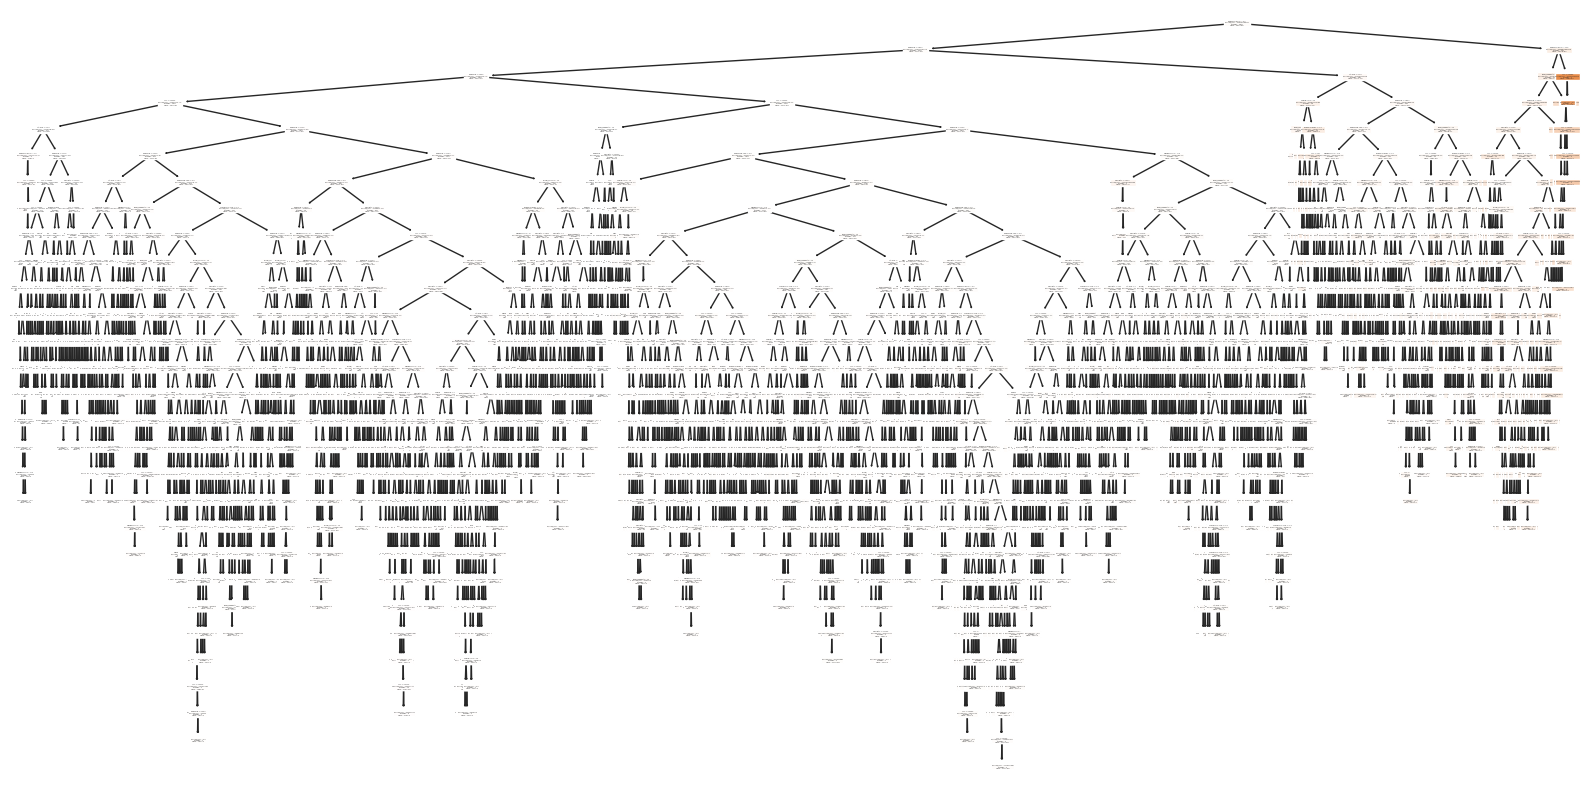

In [36]:
# Visualización del árbol

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=X_train.columns)
plt.show()

In [36]:
# Arbol sencillo e interpretable
dts = DecisionTreeRegressor(random_state=42, max_depth=3, min_samples_split=5, min_samples_leaf=10)
dts.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, min_samples_split=5,
                      random_state=42)

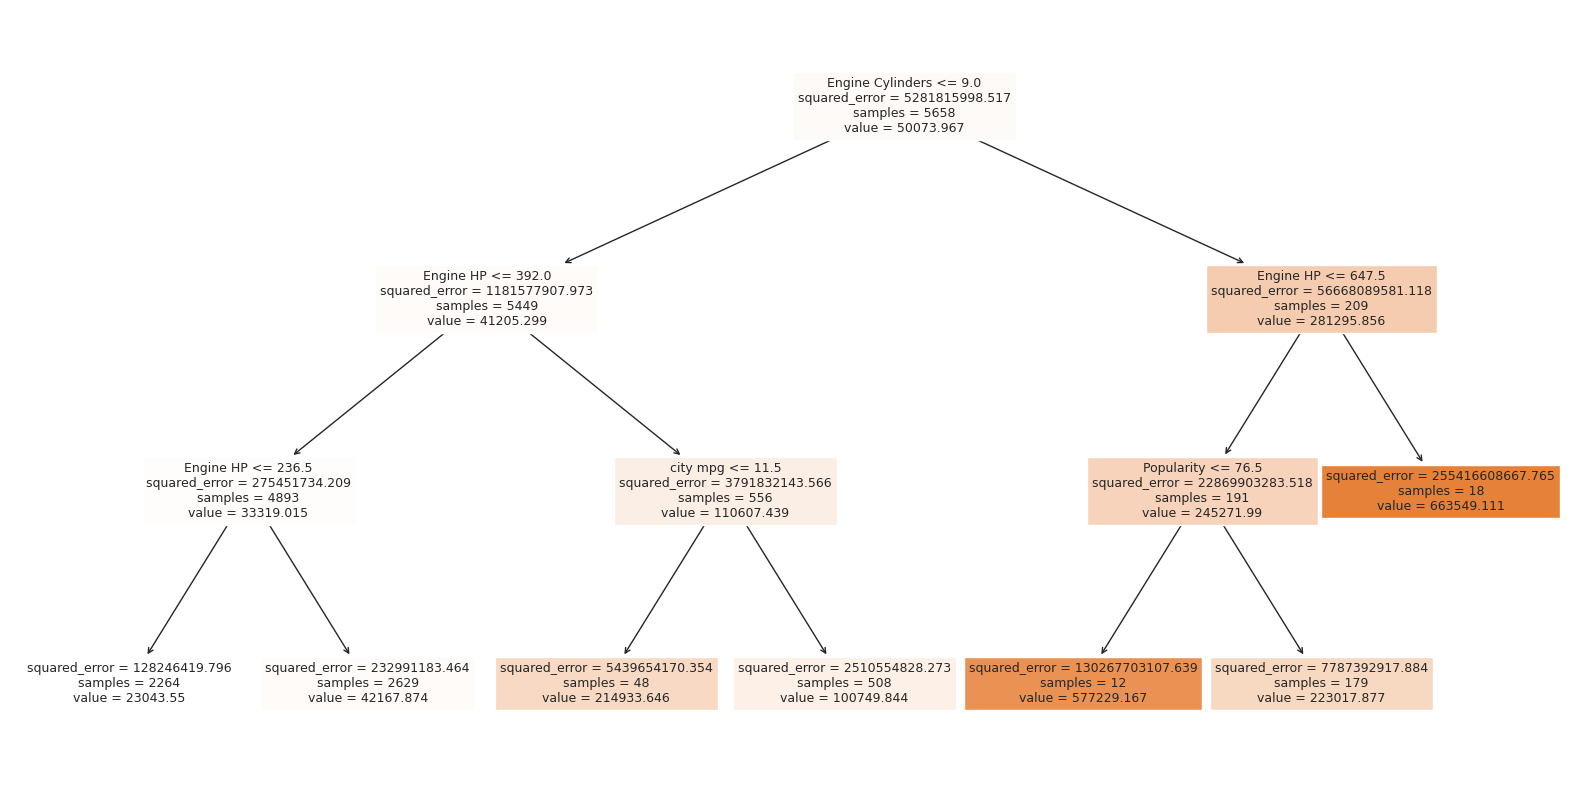

In [37]:
plt.figure(figsize=(20,10))
plot_tree(dts, filled=True, feature_names=X_train.columns)
plt.show()

In [38]:
# predicciones en train
y_pred = dts.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 15794.715103633242, R2: 0.6655791897180573


### Hiperparámetros


In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
# Definimos los hiperparámetros
param_grid = {
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

In [40]:
# Definimos el modelo
dt = DecisionTreeRegressor(random_state=42)

In [42]:
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits


GridSearchCV(cv=2, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 9, 11],
                         'min_samples_leaf': [1, 2, 4, 6, 8],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [43]:
# Mejores hiperparámetros
grid_search.best_params_

{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [44]:
# Mejor modelo
dt = grid_search.best_estimator_

In [45]:
# Predicciones en train
y_pred = dt.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 5203.567791278965, R2: 0.9348866833814068


In [46]:
# Predicciones en test
y_pred = dt.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 6501.310403394034, R2: 0.9068146417965847


In [47]:
rd_model = pd.DataFrame({'Modelo': ['Árbol de Decisión (GridSearch)'], 'MAE': [mae], 'R2': [r2]})

In [48]:
metricas_modelos = pd.concat([metricas_modelos, rd_model], axis=0)

In [49]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815


In [50]:
# Importancia de las variables
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

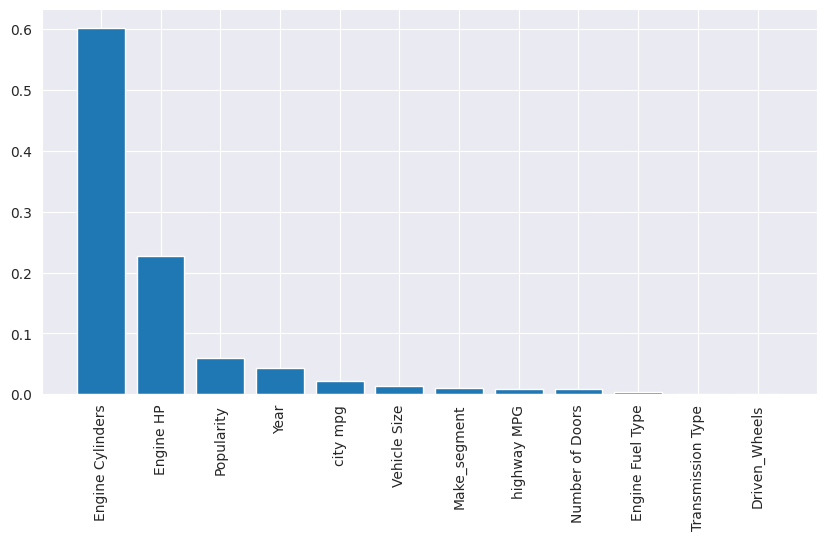

In [51]:
# Visualización de la importancia de las variables
plt.figure(figsize=(10,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.show()

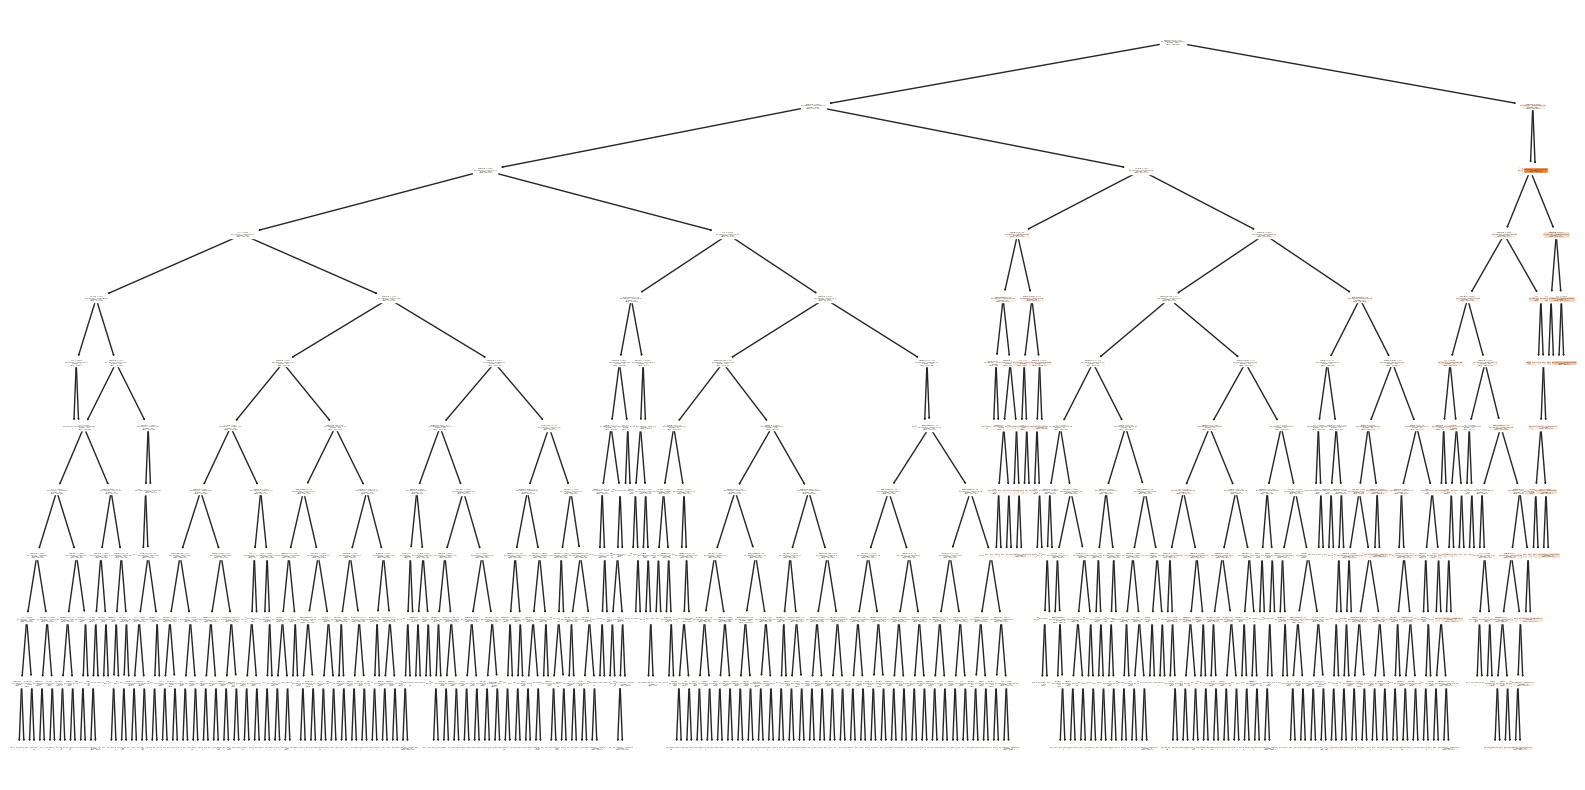

In [50]:
# visualización del mejor árbol
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=X_train.columns)
plt.show()

## Random Forest

El bosque aleatorio es un algoritmo de aprendizaje supervisado que se utiliza para problemas de regresión y clasificación. Es una técnica de conjunto que crea múltiples árboles de decisión y los combina para hacer una predicción. La idea detrás del bosque aleatorio es que la sabiduría de la multitud supera la de los individuos. En general, los bosques aleatorios logran una precisión mucho mayor que los árboles de decisión con una mayor cantidad de hiperparámetros para ajustar. La desventaja es que un bosque aleatorio es menos interpretable y más lento de entrenar y predecir que un solo árbol de decisión.

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
rf = RandomForestRegressor(random_state=42)

In [54]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [55]:
# Predicciones en train
y_pred = rf.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 3059.8480684060646, R2: 0.9476890900427495


In [56]:
# Predicciones en test
y_pred = rf.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 4695.4805504789465, R2: 0.9522816966053739


In [57]:
rf_model = pd.DataFrame({'Modelo': ['Random Forest'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, rf_model], axis=0)
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282


In [58]:
# GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 12, 14],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6]
}

In [59]:
# Definimos el modelo
rf = RandomForestRegressor(random_state=42)

In [60]:
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

In [62]:
# Entrenamiento
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 12, 14],
                         'min_samples_leaf': [1, 3, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [63]:
# Mejores hiperparámetros
grid_search.best_params_

{'max_depth': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [64]:
# Predicciones en train
y_pred = grid_search.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 3810.8539312968096, R2: 0.9379392893071762


In [65]:
# Predicciones en test
y_pred = grid_search.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 4753.081437743976, R2: 0.9596292411098184


In [66]:
rf_model = pd.DataFrame({'Modelo': ['Random Forest (GridSearch)'], 'MAE': [mae], 'R2': [r2]})

In [67]:
metricas_modelos = pd.concat([metricas_modelos, rf_model], axis=0)

In [68]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629


In [69]:
# Importancia de las variables
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

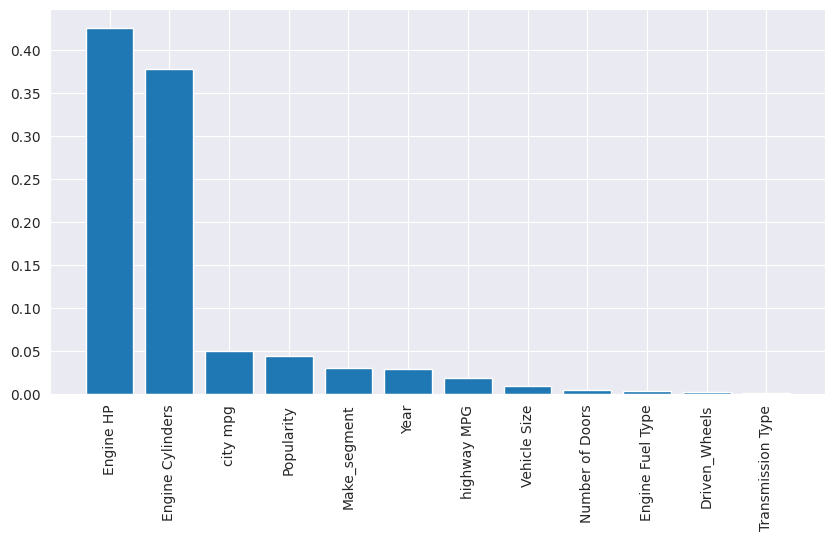

In [70]:
# Visualización de la importancia de las variables
plt.figure(figsize=(10,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.show()

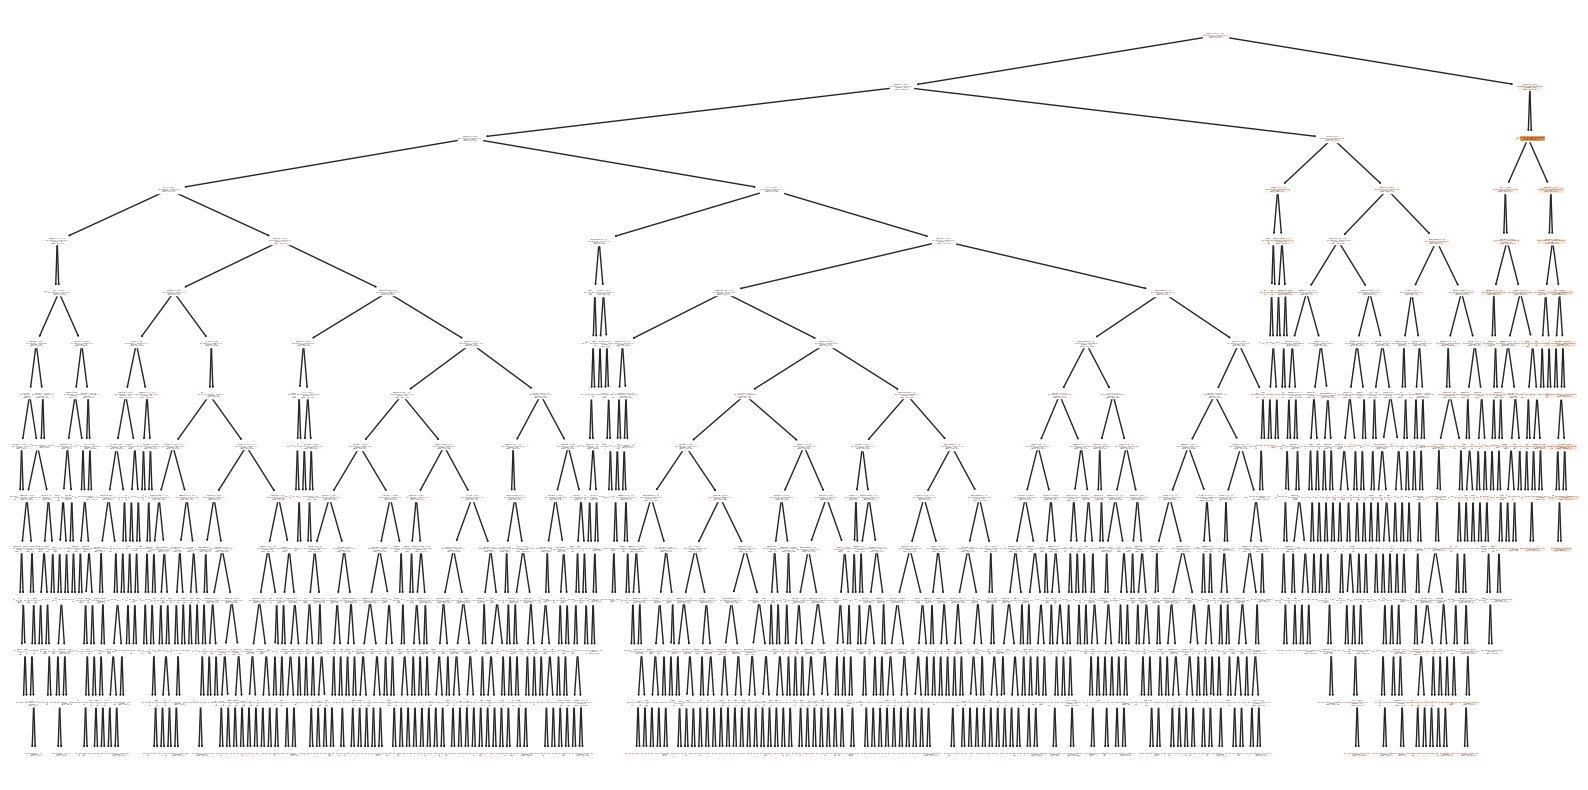

In [71]:
# Visualización de un árbol del bosque
plt.figure(figsize=(20,10))
plot_tree(grid_search.best_estimator_.estimators_[0], filled=True, feature_names=X_train.columns)
plt.show()

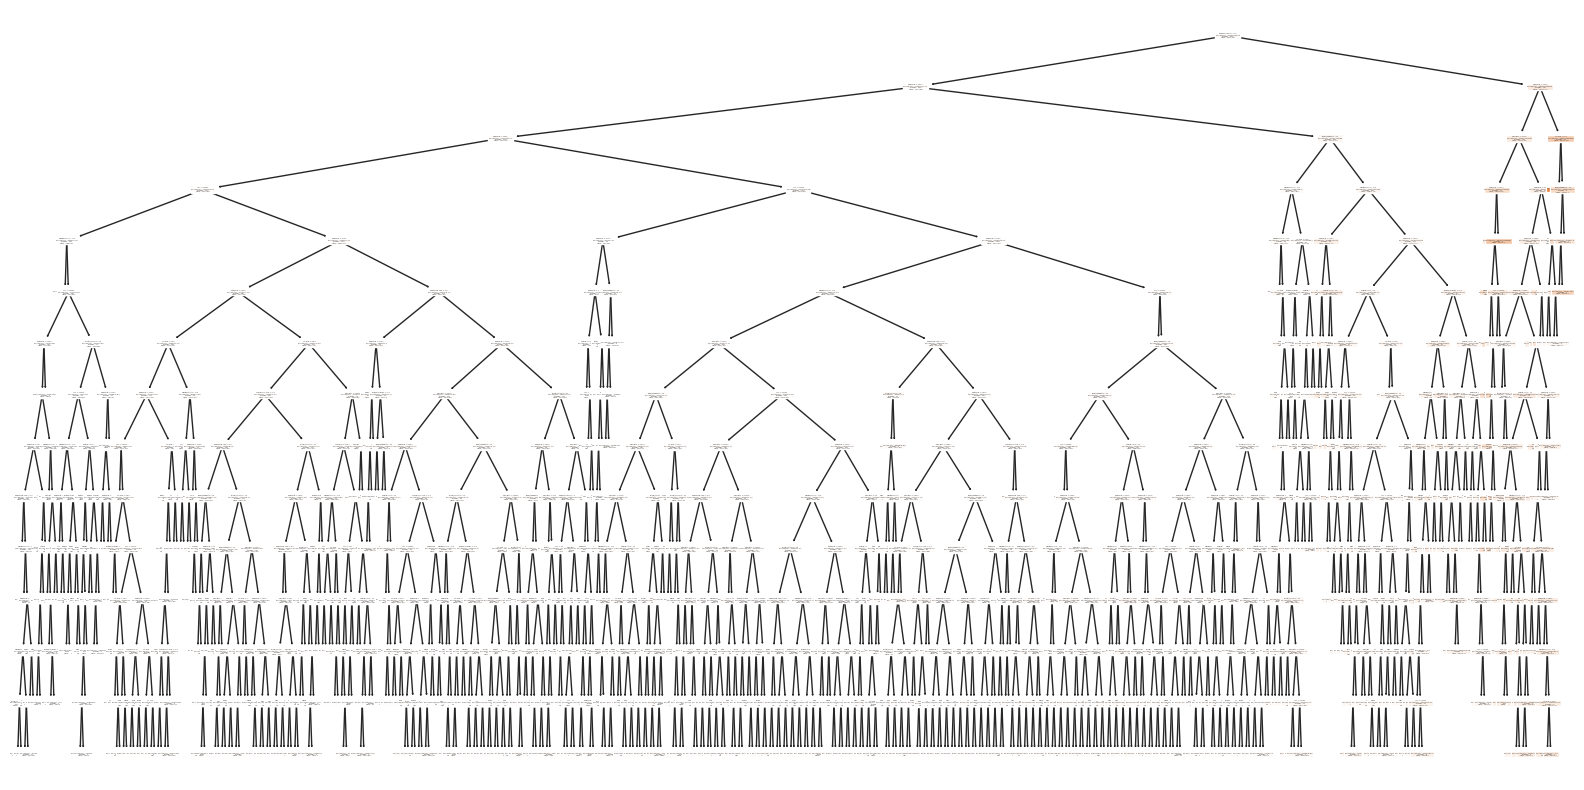

In [72]:
# Visualización de un árbol del bosque
plt.figure(figsize=(20,10))
plot_tree(grid_search.best_estimator_.estimators_[99], filled=True, feature_names=X_train.columns)
plt.show()

## Gradient Boosting (XGBoost)

El XGBoost es una implementación de la técnica de refuerzo de gradiente que se utiliza para problemas de regresión y clasificación. XGBoost es una de las bibliotecas de aprendizaje automático más populares y ampliamente utilizadas entre los practicantes de aprendizaje automático. XGBoost se basa en la técnica de refuerzo de gradiente, que produce un modelo de ensamblaje de árboles de decisión. XGBoost ajusta secuencialmente los árboles de decisión para corregir los errores de los modelos anteriores. La principal diferencia entre XGBoost y otros algoritmos de refuerzo de gradiente es su capacidad para manejar datos dispersos.

In [96]:
xgb_mod = xgb.XGBRegressor(random_state=42)

In [97]:
# Entrenamiento
xgb_mod.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [98]:
# Predicciones en train
y_pred = xgb_mod.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 3101.2256321345762, R2: 0.9604556239916422


In [99]:
# Predicciones en test
y_pred = xgb_mod.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 4757.664698236753, R2: 0.9244702248117339


In [82]:
# Guardamos las métricas
xgb_model = pd.DataFrame({'Modelo': ['XGBoost'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, xgb_model], axis=0)

In [83]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470


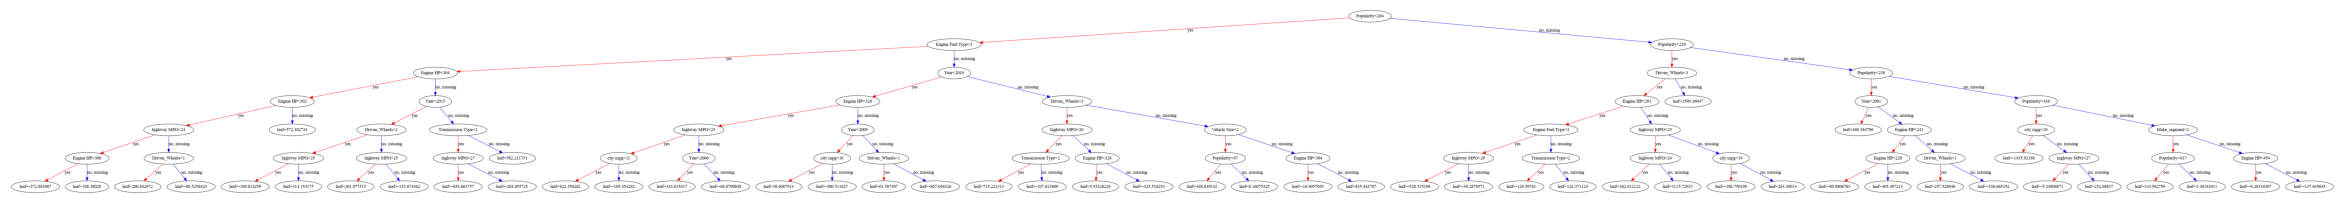

In [105]:
# Grafica un arbol
xgb.plot_tree(xgb_mod, num_trees=99)
fig = plt.gcf()
fig.set_size_inches(30, 15)

Extra: Probar una implementación en LightGBM o CatBoost